1) parameters tune

2) learning curve

3) является ли предыдущая строка продолжением следующей - сделать лучше + тесты

4) разбить на модули

In [1]:
import re
import cv2
import json
import numpy as np
from functools import reduce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import xgbfir
from itertools import product
from sklearn.utils import shuffle

In [2]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1 1
            re.compile(r'\d+[\)\}]'), # 1) 2
            re.compile(r'\w+(\.\w+)+\W'), # 3
            re.compile(r'[а-яА-Я\d]+(\.[а-яА-Я\d]+)+\W'), # b.b.b 4
            re.compile(r'[\wа-яА-Я]\.\W'), # b. 5
            re.compile(r'[6а-яА-Яa-zA-Z][\)\}]'), # б) 6
            re.compile(r'\-|—'), # - 7
            re.compile(r'®|\*'), # * 8
            re.compile(r'[a-zа-я]'), # строчная буква в начале 9
            re.compile(r'[A-ZА-Я]'),  # заглавная буква в начале 10
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья'), # 11 
            re.compile(r'[\wа-я] ')] # 12

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
        i += 1
        
    return features

In [3]:
end_reg_expr = [re.compile(r'.*\.'),
                re.compile(r'.*;'),
                re.compile(r'.*:'),
                re.compile(r'.*,'),
                re.compile(r'.*[\wа-яА-Я]'),
                re.compile(r'[А-ЯA-Z\.,\s]+')] # uppercase

def add_end_reg_features(line):
    features = [0] * len(end_reg_expr)
    i = 0
    for expr in end_reg_expr:
        match = expr.fullmatch(line)
        if match:
            features[i] = 1
        i += 1
    return features

In [4]:
# 1.1.1 -> 1.1.2
# 1) -> 2)
# 1. -> 2.
# -

# unit tests!!!
# analyzing previous lines

RE_LIST1 = re.compile(r'\d+(\.\d+)+\D') # 1.1.1
RE_LIST2 = re.compile(r'\d+[\)\.]\s') # 1) 1.
RE_LIST3 = re.compile(r'\-|—') # -
RE_LIST4 = re.compile(r'[a-zA-Zа-яА-Я][\)\.]\s') # a)

def list_continue(doc_info, line, line_num):
    match = RE_LIST1.match(line)
    if match:
        last_num = int(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == int(match.group()[-2]) + 1
        return False
    match = RE_LIST2.match(line)
    if match:
        last_num = int(match.group()[:-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST2.match(doc_line)
            if match:
                return last_num == int(match.group()[:-2]) + 1
        return False
    match = RE_LIST3.match(line)
    if match:
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST3.match(doc_line)
            if match:
                return True
        return False
    match = RE_LIST4.match(line)
    if match:
        last_num = ord(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == ord(match.group()[-2]) + 1
        return False
    return False

In [5]:
# font-weight detection

def bold_mean_color(bbox, img, d_ksize, e_ksize):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    kernel = np.ones((d_ksize, d_ksize),np.uint8)
    dilation = cv2.dilate(crop_img, kernel, iterations = 1)
    kernel = np.ones((e_ksize, e_ksize),np.uint8)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    avg_color_per_row = np.average(erosion, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [6]:
# amount letters of the first word in line

RE_WORD = re.compile(r'[a-zA-Zа-яА-Я]+')
RE_FIRST = re.compile(r'\S+\s')

def letters_cnt(line):
    res = [0, 0, 0]
    match = RE_WORD.search(line)
    if match:
        if match.start() == 0: # word in the beginning of the line
            res[0] = len(match.group(0))
    match = RE_FIRST.search(line)
    if match:
        if match.start() == 0: # some characters in the beginning of the line
            res[1] = len(match.group(0))
    words = line.split()
    if len(words) >= 2:
        res[2] = len(words[1])
    return res

In [7]:
def add_bold_mean_colors(bbox, img, num):
    res = []
    for i in range(2, num + 1):
        res.append(bold_mean_color(bbox, img, i, i ))
    return res

In [8]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            num_bold = 7
            img = cv2.imread('docs/' + doc_name)
            heigth = img.shape[0]
            width = img.shape[1]
            i = 0
            for line_info in doc_info:
                list_cont = list_continue(doc_info, line_info['text'], i) # several different features???
                word_cnt = len(line_info['text'].split())
                line_length = len(line_info['text'])
                
                line_features = [line_info['bbox'][0] / width, # left
                                 line_info['bbox'][1] / heigth, # top
                                 line_info['bbox'][3] / heigth, # height
                                 line_length, word_cnt, list_cont] 
                line_features += add_bold_mean_colors(line_info['bbox'], img, num_bold)
                line_features += letters_cnt(line_info['text'])
                line_features += add_reg_features(line_info['text'])
                line_features += add_end_reg_features(line_info['text'])
                doc_features.append(line_features)
                i += 1
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [9]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [10]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            l = len(doc_features)
            mean_left = np.sum(list(map(lambda x: x[0], doc_features))) / l
            mean_heigth = np.sum(list(map(lambda x: x[2], doc_features))) / l
            mean_line_length = np.sum(list(map(lambda x: x[3], doc_features))) / l
            mean_word_cnt = np.sum(list(map(lambda x: x[4], doc_features))) / l
            mean_bold_color = np.sum(list(map(lambda x: x[9], doc_features))) / l # bold5
            mean_word_letters_cnt = np.sum(list(map(lambda x: x[12], doc_features))) / l 
            for line_features in doc_features:
                new_features = add_prev_next_features(doc_features, line_features, i)
                i += 1
                new_features += [mean_left, mean_heigth, mean_line_length, 
                                 mean_word_cnt, mean_bold_color, mean_word_letters_cnt]
                result.append(new_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [60]:
label2class = {
    "header" : 1,
    "list" : 2,
    "text" : 3,
    "other" : 4
}

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [label2class[line['label']] for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

In [12]:
aif = AddImgFeatures()
X = np.array(aif.transform(X))

In [83]:
import pickle as pkl
clf = pkl.load(open("res_model.pkl", "rb"))
clf.get_params()

{'memory': None,
 'steps': [('addprevnextfeatures',
   <__main__.AddPrevNextFeatures at 0x7f93af994290>),
  ('xgbclassifier',
   XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
                 importance_type='gain', interaction_constraints=None,
                 learning_rate=0.1, max_delta_step=0, max_depth=7,
                 min_child_weight=2, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
                 objective='multi:softprob', random_state=0, reg_alpha=0.01,
                 reg_lambda=1, scale_pos_weight=None, subsample=1,
                 tree_method=None, validate_parameters=False, verbosity=None))],
 'verbose': False,
 'addprevnextfeatures': <__main__.AddPrevNextFeatures at 0x7f93af994290>,
 'xgbclassifier': XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1

In [84]:
model = make_pipeline(AddPrevNextFeatures(),
                                  XGBClassifier(
                                      learning_rate=0.1,
                                      n_estimators=1000,
                                      colsample_bytree=1,
                                      subsample=1,
                                      gamma=0.0,
                                      reg_alpha=0.01,
                                      min_child_weight=2,
                                      max_depth=7
                                  ))

X, y = shuffle(X, y, random_state=0)
X_train, X_test = X[:400], X[400:]
y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:400]))
y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[400:]))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
score

0.9892182528963529

In [86]:
y_pred

array([3, 3, 2, ..., 3, 2, 3])

In [89]:
from sklearn.metrics import confusion_matrix

class2label = {
    1: "Header", 
    2: "List", 
    3: "Text", 
    4: "Other"
}

y_test = [class2label[y] for y in y_test]
y_pred = [class2label[y] for y in y_pred]

confusion_matrix(y_test, y_pred, labels=['Header', 'List', 'Text', 'Other'])

array([[ 162,    4,    0,    0],
       [   8, 1794,    1,    0],
       [   1,    2, 5151,    0],
       [   0,    0,    0,    2]])

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf_matrix.png')

Confusion matrix, without normalization
[[ 162    4    0    0]
 [   8 1794    1    0]
 [   1    2 5151    0]
 [   0    0    0    2]]


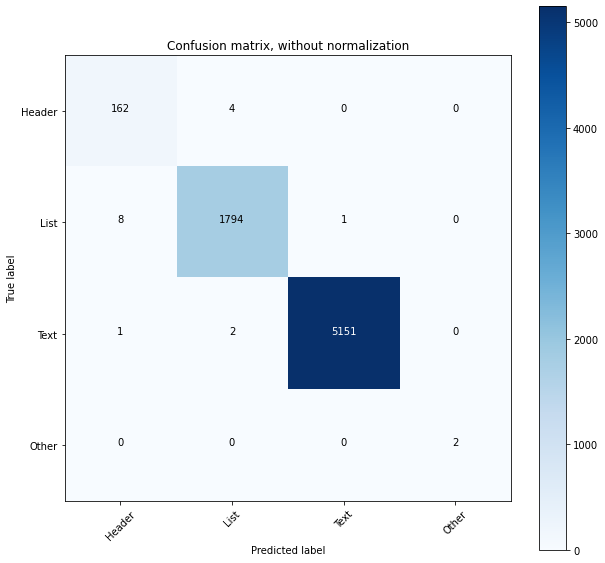

In [93]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=['Header', 'List', 'Text', 'Other'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Header', 'List', 'Text', 'Other'],
                      title='Confusion matrix, without normalization')